In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
#np.set_printoptions(threshold=np.inf)

In [2]:
def logreg_predict_prob(W, b, X):
    # defining variables
    k = W.shape[0] + 1
    n = X.shape[0]
    # solution to be returned
    P = np.zeros((n, k)).astype(np.float64)
    # creating x bar
    X_bar = np.column_stack((X, [1]*n))
    # creating weights with bias included
    theta = np.column_stack((W, b))
    # produce all theta * X, shape will be (n,k-1)
    prod_matrix = X_bar.dot(np.transpose(theta))
    # appending 0 for class 0 shape should be (n, k)
    prod_matrix = np.column_stack(([0]*prod_matrix.shape[0], prod_matrix))
    
    # find a = max{a_0, a_1, ... , a_k-1} for all i
    a = np.amax(prod_matrix, axis=1)
    # theta*X - a
    prod_matrix = (prod_matrix.transpose() - a).transpose()
    # exp(theta*X - a)
    exp_matrix = np.exp(prod_matrix)
    
    ## going through all samples and all classes
    #for i in range(0, n):
    #    for j in range(0, k):
    #        numerator = exp_matrix[i][j]
    #        denominator = np.sum(exp_matrix[i,:])
    #        #print(numerator, denominator)
    #        P[i][j] = np.float64(numerator)/np.float64(denominator)
    denominator = []
    for i in range(0,n):
        denominator.append(np.sum(exp_matrix[i,:]))
    return (exp_matrix.T/np.array(denominator)).T

In [3]:
def logreg_fit(X, y, m, eta_start, eta_end, epsilon, max_epoch=1000, log_epsilon=0.00001):
    d = X.shape[1]
    n = X.shape[0]
    #print(n)
    k = np.amax(y)+1
    # init values, shape should be (n, d+1)
    X_bar = np.column_stack((X, [1]*n))
    theta = np.random.rand(k-1, d+1)
    # Creating batches
    batches = np.array_split(X_bar, n/m)
    y_batches = np.array_split(y, n/m)
    # init eta
    eta = eta_start
    for epoch in range(1,max_epoch+1):
        theta_old = np.copy(theta)
        probability = logreg_predict_prob(theta_old[:,0:d], theta_old[:,d], X)
        prob_batch = np.array_split(probability,n/m)
        for bi in range(0, len(batches)):
            # define delta matrix for all samples in a batch for each classes
            # column is (0,1) for all samples in batch 
            # row is classes
            delta = np.array([y_batches[bi]==i for i in range(1,k)])
            # define probabiliy given class as matrix
            # column are classes
            # rows are batch size
            pc = (np.array([prob_batch[bi][i] for i in range(0, batches[bi].shape[0])])[:,1:]).transpose()
            # partial derivative of average negaitve likelihood
            pd = (-1/batches[bi].shape[0])*(delta-pc).dot(batches[bi])
            # update all theta vectors
            theta = theta - eta*pd
        # calculate new probability matrix for current loss
        probability_new = logreg_predict_prob(theta[:,0:d],theta[:,d], X)
        n_list = [i for i in range(0,n)]
        a = probability[n_list, y[n_list]]
        b = probability_new[n_list, y[n_list]]
        # prevent probability 0
        for i in range(0, probability.shape[0]):
            if a[i] == 0:
                a[i] = log_epsilon
            if b[i] == 0:
                b[i] = log_epsilon
            if a[i] == 1:
                a[i] = a[i] - log_epsilon
            if b[i] == 1:
                b[i] = b[i] - log_epsilon
        L_old = -1 * np.mean(np.log(a))
        L = -1 * np.mean(np.log(b))
        if L_old-L < epsilon*L_old:
            eta = eta/10
        if eta < eta_end:
            break;
    W = np.copy(theta[:,0:d])
    b = np.copy(theta[:,d])
    return [W,b]

In [4]:
def logreg_predict_class(W, b, X):
    probability = logreg_predict_prob(W, b, X)
    #print(probability)
    y_est = np.argmax(probability, axis=1)
    return y_est

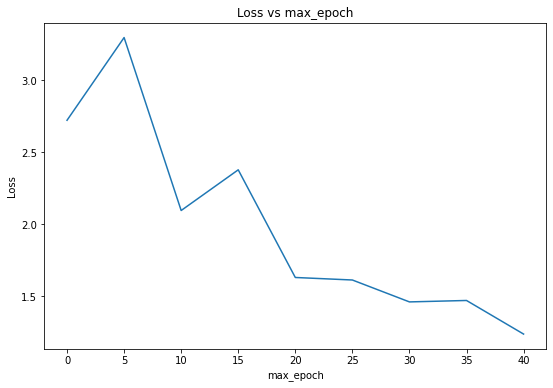

In [5]:
#def main():
# Load train set
df_train = np.genfromtxt(fname='./train.csv', delimiter=',', skip_header=1, dtype=np.float64)
X_train = df_train[:, :-1]
y_train = df_train[:, -1].astype(np.int)

# Load test set
df_test = np.genfromtxt(fname='./test.csv', delimiter=',', skip_header=1, dtype=np.float64)
X_test = df_test[:, :-1]
y_test = df_test[:, -1].astype(np.int)

# scale
scaler = StandardScaler()
Xtrain_trans = scaler.fit_transform(X_train, y_train)

# fit
m = 256
eta_start = 0.01
eta_end = 0.00001
epsilon = 0.0001
weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon)

#def vec(a):
#    n = Xtrain_trans.shape[0]
#    plt_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, a)
#    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], Xtrain_trans)
#    n_list = [i for i in range(0,n)]
#    L = -1 * np.mean(np.log(prob[n_list, y_train[n_list]]))
#    return L
#vfunc = np.vectorize(vec)
#max_epochs = [i for i in range(0,41,5)]
#losses = vfunc(max_epochs)
# Plot
losses = []
n = Xtrain_trans.shape[0]
for max_epoch in range(0, 41, 5):
    plt_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, max_epoch)
    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], Xtrain_trans)
    n_list = [i for i in range(0,n)]
    L = -1 * np.mean(np.log(prob[n_list, y_train[n_list]]))
    losses.append(L)
plt.figure(figsize=(9,6))
xaxis = np.linspace(0,40, 9, dtype=np.int)
plt.plot(xaxis, losses)
plt.title('Loss vs max_epoch')
plt.xlabel('max_epoch')
plt.ylabel('Loss')
plt.savefig('Loss vs max_epoch')
plt.show()
   
#print(weights)

In [6]:
# Question 3.1a
# As the maximum number of epochs increases the loss decreases

# main()

#Question 3.1b
# Predictions
Xtest_trans = scaler.transform(X_test, copy=True)
y_train_est = logreg_predict_class(weights[0], weights[1], Xtrain_trans)
y_test_est = logreg_predict_class(weights[0], weights[1], Xtest_trans)

# Accuracy test with sklearn
a_train = accuracy_score(y_train, y_train_est)
a_test = accuracy_score(y_test, y_test_est)
print('Train Accuracy(sklearn):', a_train)
print('Test Accuracy(sklearn):', a_test)

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_est)
cm_test = confusion_matrix(y_test, y_test_est)
print('Train Confusion matrix: ')
print(cm_train)
print('Test Confusion matrix: ')
print(cm_test)
print('Computed Train Accuracy(matrix):', (cm_train[0][0]+cm_train[1][1])/Xtrain_trans.shape[0])
print('Computed Test Accuracy(matrix):', (cm_test[0][0]+cm_test[1][1])/Xtest_trans.shape[0])

Train Accuracy(sklearn): 0.9403039073806078
Test Accuracy(sklearn): 0.9088277858176556
Train Confusion matrix: 
[[2485   44]
 [ 121  114]]
Test Confusion matrix: 
[[611  24]
 [ 39  17]]
Computed Train Accuracy(matrix): 0.9403039073806078
Computed Test Accuracy(matrix): 0.9088277858176556


Precision: 0.4146341463414634


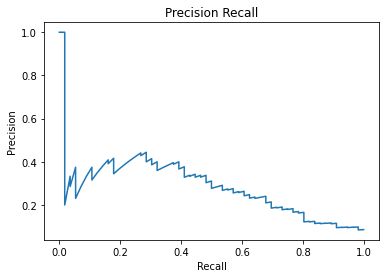

In [7]:
# Quesiton 3.1.c
P = logreg_predict_prob(weights[0], weights[1], Xtest_trans)
print('Precision:', cm_test[1][1]/(cm_test[0][1]+cm_test[1][1]))
#print(y_test.shape)
precision, recall, thresholds = precision_recall_curve(y_test, P[:, 1])
plt.plot(recall, precision)
plt.title('Precision Recall')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('Precision Recall')
plt.show()

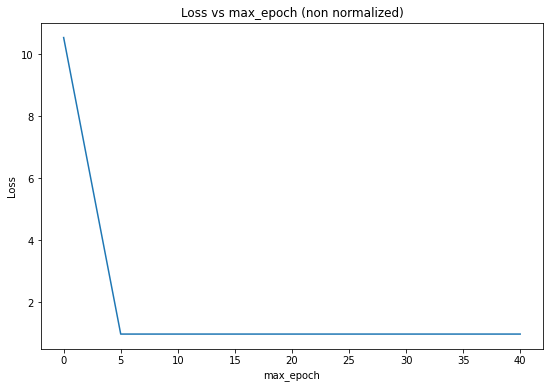

In [8]:
# Question 3.2a
weights_nt = logreg_fit(X_train, y_train, m, eta_start, eta_end, epsilon)
losses_nt = []
n = Xtrain_trans.shape[0]
for max_epoch in range(0, 41, 5):
    plt_weights = logreg_fit(X_train, y_train, m, eta_start, eta_end, epsilon, max_epoch)
    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], X_train)
    n_list = [i for i in range(0,n)]
    a = prob[n_list, y_train[n_list]]
    for i in range(0, a.shape[0]):
        if a[i] == 0:
            a[i] = 0.00001
        if a[i] == 1:
            a[i] = a[i] - 0.00001
    L = -1 * np.mean(np.log(a))
    losses_nt.append(L)
plt.figure(figsize=(9,6))
xaxis = np.linspace(0,40, 9, dtype=np.int)
plt.plot(xaxis, losses_nt)
plt.title('Loss vs max_epoch (non normalized)')
plt.xlabel('max_epoch')
plt.ylabel('Loss')
plt.savefig('Loss vs max_epoch (non normalized)')
plt.show()

In [9]:
y_train_est = logreg_predict_class(weights_nt[0], weights_nt[1], X_train)
y_test_est = logreg_predict_class(weights_nt[0], weights_nt[1], X_test)

# Accuracy test with sklearn
a_train = accuracy_score(y_train, y_train_est)
a_test = accuracy_score(y_test, y_test_est)
print('Train Accuracy(sklearn):', a_train)
print('Test Accuracy(sklearn):', a_test)

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_est)
cm_test = confusion_matrix(y_test, y_test_est)
print('Train Confusion matrix: ')
print(cm_train)
print('Test Confusion matrix: ')
print(cm_test)
print('Computed Train Accuracy(matrix):', (cm_train[0][0]+cm_train[1][1])/Xtrain_trans.shape[0])
print('Computed Test Accuracy(matrix):', (cm_test[0][0]+cm_test[1][1])/Xtest_trans.shape[0])

Train Accuracy(sklearn): 0.9149782923299565
Test Accuracy(sklearn): 0.918958031837916
Train Confusion matrix: 
[[2529    0]
 [ 235    0]]
Test Confusion matrix: 
[[635   0]
 [ 56   0]]
Computed Train Accuracy(matrix): 0.9149782923299565
Computed Test Accuracy(matrix): 0.918958031837916


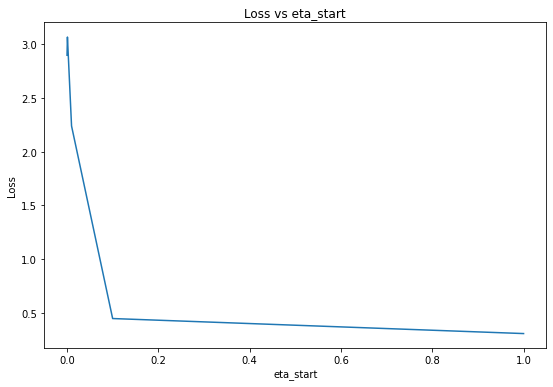

In [10]:
# Question 3.2b
eta_start_list = [0.0001, 0.001, 0.01, 0.1, 1]
losses = []
n = Xtrain_trans.shape[0]
for eta_start in eta_start_list:
    plt_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, max_epoch = 10)
    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], Xtrain_trans)
    n_list = [i for i in range(0,n)]
    L = -1 * np.mean(np.log(prob[n_list, y_train[n_list]]))
    losses.append(L)
plt.figure(figsize=(9,6))
plt.plot(eta_start_list, losses)
plt.title('Loss vs eta_start')
plt.xlabel('eta_start')
plt.ylabel('Loss')
plt.savefig('Loss vs eta_start')
plt.show()

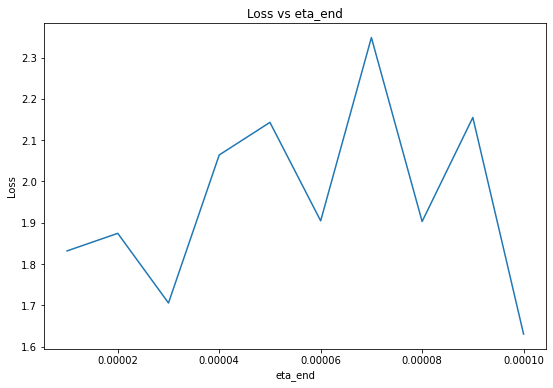

In [11]:
eta_end_list = np.linspace(0.00001, 0.0001, 10) #[i for i in range (0.00001,0.0001, 0.00001)]
eta_start = 0.01
losses = []
n = Xtrain_trans.shape[0]
for eta_end in eta_end_list:
    plt_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, max_epoch = 15)
    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], Xtrain_trans)
    n_list = [i for i in range(0,n)]
    L = -1 * np.mean(np.log(prob[n_list, y_train[n_list]]))
    losses.append(L)
plt.figure(figsize=(9,6))
plt.plot(eta_end_list, losses)
plt.title('Loss vs eta_end')
plt.xlabel('eta_end')
plt.ylabel('Loss')
plt.savefig('Loss vs eta_end')
plt.show()

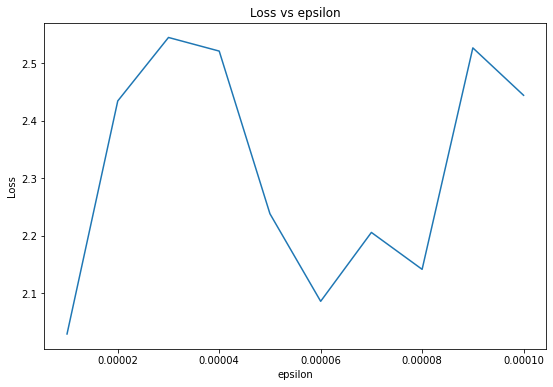

In [12]:
epsilon_list = np.linspace(0.00001, 0.0001, 10)
eta_end = 0.00001
losses = []
n = Xtrain_trans.shape[0]
for epsilon in epsilon_list:
    plt_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, max_epoch = 10)
    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], Xtrain_trans)
    n_list = [i for i in range(0,n)]
    L = -1 * np.mean(np.log(prob[n_list, y_train[n_list]]))
    losses.append(L)
plt.figure(figsize=(9,6))
plt.plot(epsilon_list, losses)
plt.title('Loss vs epsilon')
plt.xlabel('epsilon')
plt.ylabel('Loss')
plt.savefig('Loss vs epsilon')
plt.show()

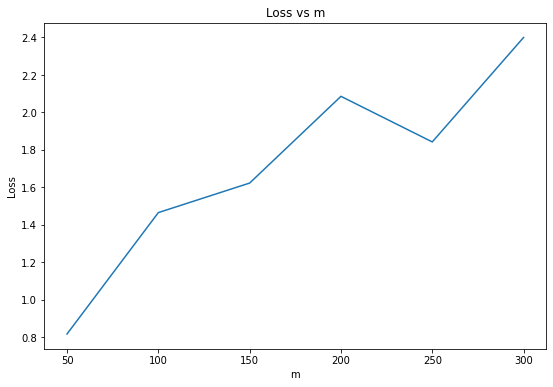

In [13]:
m_list = [50, 100, 150, 200, 250, 300]
epsilon = 0.0001
losses = []
n = Xtrain_trans.shape[0]
for m in m_list:
    plt_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, max_epoch = 10)
    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], Xtrain_trans)
    n_list = [i for i in range(0,n)]
    L = -1 * np.mean(np.log(prob[n_list, y_train[n_list]]))
    losses.append(L)
plt.figure(figsize=(9,6))
plt.plot(m_list, losses)
plt.title('Loss vs m')
plt.xlabel('m')
plt.ylabel('Loss')
plt.savefig('Loss vs m')
plt.show()

In [14]:
# Question 3.2c
eta_start = 1
eta_end = 0.00009
epsilon = 0.00009
m = 50


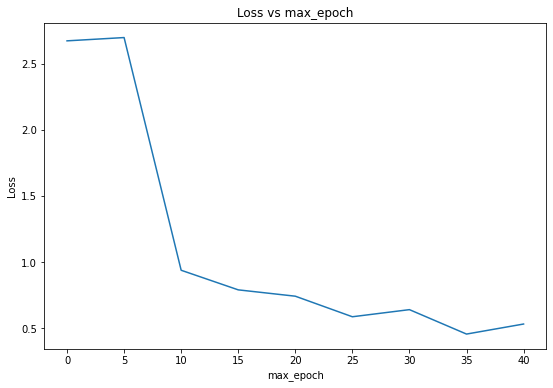

In [15]:
losses = []
n = Xtrain_trans.shape[0]
for max_epoch in range(0, 41, 5):
    plt_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, max_epoch)
    prob = logreg_predict_prob(plt_weights[0], plt_weights[1], Xtrain_trans)
    n_list = [i for i in range(0,n)]
    L = -1 * np.mean(np.log(prob[n_list, y_train[n_list]]))
    losses.append(L)
plt.figure(figsize=(9,6))
xaxis = np.linspace(0,40, 9, dtype=np.int)
plt.plot(xaxis, losses)
plt.title('Loss vs max_epoch')
plt.xlabel('max_epoch')
plt.ylabel('Loss')
plt.savefig('Loss vs max_epoch 32c')
plt.show()

In [16]:
final_weights = logreg_fit(Xtrain_trans, y_train, m, eta_start, eta_end, epsilon, max_epoch=100)
y_train_est = logreg_predict_class(final_weights[0], final_weights[1], Xtrain_trans)
y_test_est = logreg_predict_class(final_weights[0], final_weights[1], Xtest_trans)

# Accuracy test with sklearn
a_train = accuracy_score(y_train, y_train_est)
a_test = accuracy_score(y_test, y_test_est)
print('Train Accuracy(sklearn):', a_train)
print('Test Accuracy(sklearn):', a_test)

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_est)
cm_test = confusion_matrix(y_test, y_test_est)
print('Train Confusion matrix: ')
print(cm_train)
print('Test Confusion matrix: ')
print(cm_test)
print('Computed Train Accuracy(matrix):', (cm_train[0][0]+cm_train[1][1])/Xtrain_trans.shape[0])
print('Computed Test Accuracy(matrix):', (cm_test[0][0]+cm_test[1][1])/Xtest_trans.shape[0])
print('Computed Test Precision:', cm_test[1][1]/(cm_test[1][1]+cm_test[0][1]))

Train Accuracy(sklearn): 0.9417510853835022
Test Accuracy(sklearn): 0.9044862518089725
Train Confusion matrix: 
[[2465   64]
 [  97  138]]
Test Confusion matrix: 
[[603  32]
 [ 34  22]]
Computed Train Accuracy(matrix): 0.9417510853835022
Computed Test Accuracy(matrix): 0.9044862518089725
Computed Test Precision: 0.4074074074074074
